# Convolutional Neural Networks for Instrumental, Genre and Mood Recognition

This section shows how different Convolutional Neural Network architectures are used for:

* Instrumental vs. Vocal Detection: detecting whether a piece of music is instrumental or contains vocals
* Genre Classification
* Mood Recognition

## MagnaTagAtune Dataset

The dataset used is a subset of the [MagnaTagATune Dataset](http://mirg.city.ac.uk/codeapps/the-magnatagatune-dataset) with only 1 sample excerpt of each of the original audio files. The original audio files were pre-processed to extract Mel spectrograms as an input for this section; also refer to previous notebook (cuaderno 010) on how this pre-processing was done.

### How to do it...

1. Download and extract the dataset on `SPECTROGRAM_PATH`. 

In [1]:
SPECTROGRAM_PATH = '../../../Machine-Learning/ismir2018/ISMIR2018_tut_melspecs_subset'
METADATA_PATH = '../../../Machine-Learning/ismir2018/metadata'

import os

# here, %s will be replaced by 'instrumental', 'genres' or 'moods'
SPECTROGRAM_FILE_PATTERN = os.path.join(SPECTROGRAM_PATH,'ISMIR2018_tut_melspecs_part_1_%s_subset.npz')
LABEL_FILE_PATTERN = os.path.join(METADATA_PATH,'ismir2018_tut_part_1_%s_labels_subset_w_clipid.csv') 

2. Import all the required packages:

In [2]:
# General Imports
import argparse
import csv
import datetime
import glob
import math
import sys
import time
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline 

# Deep Learning
import keras
from keras import optimizers
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Input, Convolution2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, merge
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import ELU

# Machine Learning preprocessing and evaluation
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, roc_auc_score, hamming_loss
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit

## Instrumental vs. Vocal Detection

This is a binary classification task to detect whether a piece of audio is instrumental or vocal (i.e. singing or voice). The output decision is *either* 0 *or* 1.

### Load Audio Spectrograms

We already have pre-processed the audio files and extracted Mel spectrograms. We load these from a Numpy .npz file, which contains the spectrograms and also the associated clip ids:

In [3]:
task = 'instrumental'
SPECTROGRAM_FILE = SPECTROGRAM_FILE_PATTERN % task

npz = np.load(SPECTROGRAM_FILE)
spectrograms = npz['features']
spec_clip_ids = npz['clip_id']

# check how many spectrograms we have and their dimensions
spectrograms.shape

(1703, 80, 80)

In [4]:
# check whether we have the same number of clip ids
len(spec_clip_ids)

1703

In [5]:
# create a dataframe that associates the index order of the spectrograms with the clip ids
spectrograms_clip_ids = pd.DataFrame({'spec_id':np.arange(spectrograms.shape[0])}, index=spec_clip_ids)
spectrograms_clip_ids.index.name = 'clip_id'

# head of the dataframe
spectrograms_clip_ids.head()

,spec_id
clip_id,
37,0
40,1
172,2
198,3
253,4


In [6]:
# we define the same in a convenience function used later
def load_spectrograms(spectrogram_filename):
    # load spectrograms
    npz = np.load(spectrogram_filename)
    spectrograms = npz['features']
    spec_clip_ids = npz['clip_id']
    # create a dataframe that associates the index order of the spectrograms with the clip ids
    spectrograms_clip_ids = pd.DataFrame({'spec_id':np.arange(spectrograms.shape[0])}, index=spec_clip_ids)
    spectrograms_clip_ids.index.name = 'clip_id'
    return spectrograms, spec_clip_ids, spectrograms_clip_ids

Show a Mel Spectrogram ... just for illustration!!!

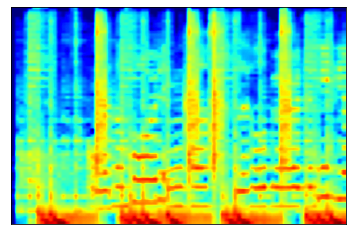

In [7]:
i = 10
spec = spectrograms[i]

fig = plt.imshow(spec, origin='lower', aspect='auto')
fig.set_cmap('jet')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

### Standardization

<b>Always standardize</b> the data before feeding it into the Neural Network! (unless we use BatchNormalization in our Neural Network).

Standardization refers to shifting the distribution of each attribute to have a mean of zero and a standard deviation of one (unit variance).

We use the [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) from the *scikit-learn* package for our purpose.
As it works typically on vector data, we have to vectorize (i.e. reshape) our matrices first, and then reshape again to the original shape. We created a convenience function for that:

In [8]:
def standardize(data):
    # vectorize before standardization 
    N, ydim, xdim = data.shape
    data = data.reshape(N, xdim*ydim)

    # standardize features by removing the mean and scaling to unit variance
    scaler = preprocessing.StandardScaler()
    data = scaler.fit_transform(data)

    # reshape to original shape
    return data.reshape(N, ydim, xdim)

In [9]:
spectrograms = standardize(spectrograms)

# verify that the shape is again the same as before
spectrograms.shape 

(1703, 80, 80)

### Load Metadata

In [10]:
task = 'instrumental'
CSV_FILE = LABEL_FILE_PATTERN % task

metadata = pd.read_csv(CSV_FILE, index_col=0)
metadata.shape

(1680, 1)

In [11]:
# dataframe
metadata

,instrumental
clip_id,
37,0.0
40,0.0
172,1.0
198,0.0
253,0.0
...,...
58459,1.0
58470,0.0
58530,1.0


In [12]:
# how many instrumental tracks
metadata.sum()

instrumental    420.0
dtype: float64

In [13]:
# how many vocal tracks
(1-metadata).sum()

instrumental    1260.0
dtype: float64

### Align Metadata and Spectrograms

We may have more spectrograms than metadata...

In [14]:
# metadata clip ids
metadata.index

Int64Index([   37,    40,   172,   198,   253,   284,   349,   422,   512,
              541,
            ...
            58254, 58282, 58295, 58310, 58405, 58459, 58470, 58530, 58606,
            58757],
           dtype='int64', name='clip_id', length=1680)

In [15]:
# spectrogram clip ids
spec_clip_ids

array([   37,    40,   172, ..., 58530, 58606, 58757])

In [16]:
# check if we find all metadata clip ids in our spectrogram data
len(set(metadata.index).intersection(set(spec_clip_ids)))

1680

### Create Train X and Y: data and classes

Get the correct spectrogram indices given the metadata's clip ids in a sorted way:

In [17]:
meta_clip_ids = metadata.index
spec_indices = spectrograms_clip_ids.loc[meta_clip_ids]['spec_id']
spec_indices

clip_id
37          0
40          1
172         2
198         3
253         4
         ... 
58459    1698
58470    1699
58530    1700
58606    1701
58757    1702
Name: spec_id, Length: 1680, dtype: int64

Select a correctly sorted subset of the original spectrograms:

In [18]:
data = spectrograms[spec_indices,:]
data.shape

(1680, 80, 80)

For training convert from Pandas DataFrame to numpy array:

In [19]:
classes = metadata.values
classes

array([[0.],
       [0.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

Number of classes is number of columns in metadata:

In [20]:
n_classes = metadata.shape[1]
n_classes

1

## Convolutional Neural Networks

A Convolutional Neural Network (ConvNet or CNN) is a type of (Deep) Neural Network that is well-suited for 2D axes data, such as images or spectrograms, as it is optimized for learning from spatial proximity. Its core elements are `2D filter kernels` (which essentially learn the weights of the Neural Network) and down-scaling functions such as `Max Pooling`.

A CNN can have one or more **Convolution layers**, each of them having an arbitrary number of `N` filters (which define the depth of the CNN layer), typically followed by a **pooling step**, which aggregates neighboring pixels together and thus reduces the image resolution by retaining only the average or maximum values of neighboring pixels.

## Preparing the Data

### Adding the channel

As CNNs were initially made for image data, we need to add a dimension for the color channel to the data. 

<b>Spectrograms, however, are considered like greyscale images. Likewise we need to add an extra dimension for compatibility with the CNN implementation.</b>

For greyscale images, we add the number `1` as the depth of the additional dimension of the input shape (for RGB color images, the number of channels is `3`).

In [21]:
def add_channel(data, n_channels=1):
    # n_channels: 1 for grey-scale, 3 for RGB, but usually already present in the data
    N, ydim, xdim = data.shape
    data = data.reshape(N, ydim, xdim, n_channels)
    return data

In [22]:
data = add_channel(data, n_channels=1)
data.shape

(1680, 80, 80, 1)

In [23]:
# we store the new shape of the images in the 'input_shape' variable.
# take all dimensions except the 0th one (which is the number of files)
input_shape = data.shape[1:]  
input_shape

(80, 80, 1)

### Train & Test Set Split

We split the original full data set into two parts: Train Set (75%) and Test Set (25%).

**NOTE:** For demo purposes we use only 1 split here. A better way to do it is to use **Cross-Validation**, doing the split multiple times, iterating training and testing over the splits and averaging the results.

In [24]:
# use 75% of data for train, 25% for test set
testset_size = 0.25

In [25]:
# provides train/test indices to split data into train/test sets
splitter = StratifiedShuffleSplit(n_splits=1, test_size=testset_size, random_state=0)
splits = splitter.split(data, classes)

for train_index, test_index in splits:
    print("TRAIN INDEX:", train_index)
    print("TEST INDEX:", test_index)
    print("number of instances TRAIN:", len(train_index))
    print("number of instances TEST:", len(test_index))
    train_set = data[train_index]
    test_set = data[test_index]
    train_classes = classes[train_index]
    test_classes = classes[test_index]

TRAIN INDEX: [ 514  949 1427 ...  463 1586  433]
TEST INDEX: [1384  929 1069  946  144  123  743 1574 1448 1031  679 1430  935  790
  189  742 1138 1059 1463  444  421  670  139  462   62  882 1168 1066
 1269   57 1096 1454   40 1481 1280 1257 1155 1569  505  488  422 1194
  698 1298 1607 1255  532  447 1441 1100  473 1156 1091  860 1308 1429
 1577 1516 1609  789  494   29  285  870  834  191  443  713 1584  810
  410  387  923  299 1259  944  657  408 1643  264 1284 1214  294  330
 1542  828  888  350  357  318 1409  793  260  173  681 1459 1504  380
 1112  361 1004 1654 1163   98  738 1145  496 1160 1174 1373  616  556
   43 1131  188  167 1360  620  163   21  907  710 1421 1171  892 1260
  794 1503 1173 1301 1528 1648  237 1592  254 1491  960 1007 1343  993
  215  314 1115 1121 1055  820 1508  955  329   39 1450 1477 1443  845
 1405  607 1644 1222  258 1539  856 1623  523   12  399 1273 1660  367
 1206  165  615  169 1281 1228  760 1005  854  965  278   79  151  338
  674 1024  722 

In [26]:
print(train_set.shape)
print(test_set.shape)

(1260, 80, 80, 1)
(420, 80, 80, 1)


## Creating Neural Network Models in Keras

### Sequential Models

In Keras, one can choose between a Sequential model and a Graph model. ***Sequential models*** are simple concatenations of layers. ***Graph models*** can also handle those but also more complex neural network architectures. Keras now recommends to use the Graph models by default, but for a simple entry into the topic we are going to start with Sequential models first.

**EXERCISE:** Try different configurations by uncommenting various lines of code in the following code box. Observe changes in:
* number of parameters in the model;
* speed of training;
* accuracy on test set.

In [27]:
#np.random.seed(0) # make results repeatable

model = Sequential()

conv_filters = 16 # number of convolution filters (= CNN depth)

# UNCOMMENT TO INCREASE FILTERS
#conv_filters = 32 # number of convolution filters (= CNN depth)

# 1st Layer
model.add(Convolution2D(conv_filters, (3,3), input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2))) 

# UNCOMMENT TO ADD 2nd LAYER
#model.add(Convolution2D(conv_filters, (3,3)))
#model.add(MaxPooling2D(pool_size=(2,2))) 

# UNCOMMENT TO ADD DROPOUT
#model.add(Dropout(0.25)) 

# After Convolution, we have a [conv_filters*y*x] matrix output
# In order to feed this to a Full (Dense) layer, we need to flatten all data
model.add(Flatten()) 

# Full layer
model.add(Dense(256, activation='sigmoid')) 

# Output layer
# For binary/2-class problems use ONE sigmoid unit, 
# for multi-class/multi-label problems use n output units and activation='softmax'
model.add(Dense(n_classes, activation='sigmoid'))

Get a nice overview of the model architecture and the number of weights (parameters) in the NN:

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 78, 78, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 39, 39, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 24336)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6230272   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 6,230,689
Trainable params: 6,230,689
Non-trainable params: 0
_________________________________________________________________


Note that there are `160` parameters in the *convolution layer* as each of the `16` filters of size `3 x 3` would have `9` weights and `1` bias term. 

As we see, the number of parameters in the *first dense layer* is `6230272`, as the `24336` input units are connected to `256` hidden units, resulting in `24336*256` weight values and `256` bias values.

Similarly, the *output layer* has `1` output, which is connected to each of the `256` hidden units, resulting in `256*1` weight values and `1` biases (a total of `257` parameters).

## Training the CNN

We have to define:

* **loss function**: `binary crossentropy` for single-class problems
(there are only two label classes assumed to be 0 and 1), `categorical crossentropy` for multi-class problems;
* **optimizer**: classic `Stochastic Gradient Descent`, or derivations thereof (e.g. `Adam`);
* **metric**: one or multiple metrics for evaluation on the train, validation and test sets;
* **epochs**: number of iterations to train the network (in the default case, at each epoch the full dataset is presented once to the network);
* **batch_size**: how many instances are presented as one batch to the network, before a weight update (= *Back Propagation*) takes place.

In [29]:
loss = 'binary_crossentropy'  
optimizer = 'sgd' 
metrics = ['accuracy']
batch_size = 32

# Compiling the model
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [30]:
# Fitting the model
# (execute multiple times to train more epochs)
epochs = 10
history = model.fit(train_set, train_classes, batch_size=batch_size, epochs=epochs)

Epoch 1/10
40/40 [==============================] - 5s 108ms/step - loss: 0.5999 - accuracy: 0.6862
Epoch 2/10
40/40 [==============================] - 4s 101ms/step - loss: 0.5220 - accuracy: 0.7684
Epoch 3/10
40/40 [==============================] - 4s 101ms/step - loss: 0.5084 - accuracy: 0.7731
Epoch 4/10
40/40 [==============================] - 4s 91ms/step - loss: 0.4838 - accuracy: 0.8025
Epoch 5/10
40/40 [==============================] - 4s 95ms/step - loss: 0.4956 - accuracy: 0.7726
Epoch 6/10
40/40 [==============================] - 3s 86ms/step - loss: 0.4653 - accuracy: 0.7954
Epoch 7/10
40/40 [==============================] - 3s 84ms/step - loss: 0.4339 - accuracy: 0.8072
Epoch 8/10
40/40 [==============================] - 4s 93ms/step - loss: 0.4314 - accuracy: 0.8289
Epoch 9/10
40/40 [==============================] - 4s 113ms/step - loss: 0.4297 - accuracy: 0.8001
Epoch 10/10
40/40 [==============================] - 4s 94ms/step - loss: 0.4128 - accuracy: 0.8316


## Verifying Accuracy on Test Set

Calculate the expected output values for a given input (`test_set`) to the model:

In [31]:
test_pred = model.predict_classes(test_set)

/home/ale/miniconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


**NOTE:** we use `predict_class` for classifiers (outputs are labels) and `predict` for regressions (outputs are non discrete).

In [32]:
# show first 10 predictions
test_pred[0:10]

array([[1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]], dtype=int32)

Calculate the accuracy classification score (fraction of correctly classified samples):

In [33]:
accuracy_score(test_classes, test_pred)

0.7880952380952381

## Additional Parameters & Techniques

**Exercise:** Try out more parameters and techniques: comment/uncomment appropriate lines of code below:
* add ReLU activation
* add Batch normalization
* add Dropout on multiple layers

**NOTA:** Batch normalization is used to stabilize and accelerate the learning process. It does so by applying a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1. For more detalis, see [Batch Normalization Tensorflow Keras Example](https://towardsdatascience.com/backpropagation-and-batch-normalization-in-feedforward-neural-networks-explained-901fd6e5393e).

In [34]:
model = Sequential()

conv_filters = 16 # number of convolution filters (= CNN depth)
filter_size = (3,3)
pool_size = (2,2)

# Layer 1
model.add(Convolution2D(conv_filters, filter_size, padding='valid', input_shape=input_shape))
#model.add(BatchNormalization())
#model.add(Activation('relu')) 
model.add(MaxPooling2D(pool_size=pool_size)) 
#model.add(Dropout(0.3))

# Layer 2
model.add(Convolution2D(conv_filters, filter_size, padding='valid', input_shape=input_shape))
#model.add(BatchNormalization())
#model.add(Activation('relu')) 
model.add(MaxPooling2D(pool_size=pool_size)) 
#model.add(Dropout(0.1))

# In order to feed this to a Full (Dense) layer, we need to flatten all data
model.add(Flatten()) 

# Full layer
model.add(Dense(256))  
#model.add(Activation('relu'))
#model.add(Dropout(0.1))

# Output layer
# For binary/2-class problems use ONE sigmoid unit, 
# for multi-class/multi-label problems use n output units and activation='softmax'
model.add(Dense(n_classes, activation='sigmoid'))

In [35]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 78, 78, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 39, 39, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 16)        2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5184)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               1327360   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [36]:
# Compile the model
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [37]:
# Fit the model
epochs = 10
history = model.fit(train_set, train_classes, batch_size=32, epochs=epochs)

Epoch 1/10
40/40 [==============================] - 5s 128ms/step - loss: 0.5587 - accuracy: 0.7100
Epoch 2/10
40/40 [==============================] - 5s 132ms/step - loss: 0.5035 - accuracy: 0.7867
Epoch 3/10
40/40 [==============================] - 5s 124ms/step - loss: 0.4743 - accuracy: 0.7993
Epoch 4/10
40/40 [==============================] - 5s 129ms/step - loss: 0.4557 - accuracy: 0.8050
Epoch 5/10
40/40 [==============================] - 5s 122ms/step - loss: 0.4242 - accuracy: 0.8319
Epoch 6/10
40/40 [==============================] - 5s 127ms/step - loss: 0.4320 - accuracy: 0.8209
Epoch 7/10
40/40 [==============================] - 5s 127ms/step - loss: 0.3971 - accuracy: 0.8266
Epoch 8/10
40/40 [==============================] - 4s 112ms/step - loss: 0.3806 - accuracy: 0.8327
Epoch 9/10
40/40 [==============================] - 5s 113ms/step - loss: 0.3962 - accuracy: 0.8365
Epoch 10/10
40/40 [==============================] - 4s 109ms/step - loss: 0.3838 - accuracy: 0.8461

In [38]:
# Verify Accuracy on Test Set
test_pred = model.predict_classes(test_set)
accuracy_score(test_classes, test_pred)

/home/ale/miniconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0.780952380952381

## Genre Classification

In this Genre classification task, we have multiple classes, but the decision has to be made for 1 target class.
This is called a single-label / multi-class task (as opposed to a multi-label task).

### Load Audio Spectrograms

We already have pre-processed the audio files and extracted Mel spectrograms. We load these from a Numpy .npz file, which contains the spectrograms and also the associated clip ids:

In [39]:
task = 'genres'
SPECTROGRAM_FILE = SPECTROGRAM_FILE_PATTERN % task

spectrograms, spec_clip_ids, spectrograms_clip_ids = load_spectrograms(SPECTROGRAM_FILE)

In [40]:
# check how many spectrograms we have and their dimensions
spectrograms.shape

(1998, 80, 80)

In [41]:
# check whether we have the same number of clip ids
len(spec_clip_ids)

1998

In [42]:
# head of the dataframe
spectrograms_clip_ids.head()

,spec_id
clip_id,
41797,0
38338,1
34335,2
25542,3
38344,4


### Standardization

Standardize the data:

In [43]:
spectrograms = standardize(spectrograms)

# verify that the shape is again the same as before
spectrograms.shape 

(1998, 80, 80)

### Load Metadata

In [44]:
task = 'genres'
CSV_FILE = LABEL_FILE_PATTERN % task

metadata = pd.read_csv(CSV_FILE, index_col=0)
metadata.shape

(1998, 8)

In [45]:
# dataframe
metadata

,classical,country,jazz,pop,rock,techno,blues,dance
clip_id,,,,,,,,
41797,0,0,0,0,1,0,0,0
38338,1,0,0,0,0,0,0,0
34335,0,0,0,0,1,0,0,0
25542,1,0,0,0,0,0,0,0
38344,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...
29845,1,0,0,0,0,0,0,0
20711,1,0,0,0,0,0,0,0
5644,0,0,1,0,0,0,0,0


In [46]:
# how many tracks per genre
metadata.sum()

classical    999
country       72
jazz          90
pop           94
rock         379
techno       341
blues          9
dance         14
dtype: int64

#### Baseline

A *dumb* classifier could assign all predictions to the biggest class. The number of tracks belonging to the biggest class divided by the total number of tracks in the dataset is our **baseline accuracy**:

In [47]:
metadata.sum().max() / len(metadata)

0.5

### Align Metadata and Spectrograms

In [48]:
# metadata clip ids
metadata.index

Int64Index([41797, 38338, 34335, 25542, 38344,  5850, 38352, 41802, 16219,
            25564,
            ...
            10411, 33862, 29692,  5346, 38094, 29845, 20711,  5644, 34175,
            41667],
           dtype='int64', name='clip_id', length=1998)

In [49]:
# spectrogram clip ids
spec_clip_ids

array([41797, 38338, 34335, ...,  5644, 34175, 41667])

In [50]:
# check if we find all metadata clip ids in our spectrogram data
len(set(metadata.index).intersection(set(spec_clip_ids)))

1998

### Create Train X and Y: data and classes

Get the correct spectrogram indices given the metadata's clip ids in a sorted way:

In [51]:
meta_clip_ids = metadata.index
spec_indices = spectrograms_clip_ids.loc[meta_clip_ids]['spec_id']
spec_indices

clip_id
41797       0
38338       1
34335       2
25542       3
38344       4
         ... 
29845    1993
20711    1994
5644     1995
34175    1996
41667    1997
Name: spec_id, Length: 1998, dtype: int64

Select a correctly sorted subset of the original spectrograms:

In [52]:
data = spectrograms[spec_indices,:]
data.shape

(1998, 80, 80)

For training convert from Pandas DataFrame to numpy array:

In [53]:
# classes needs to be a "1-hot encoded" numpy array
classes = metadata.values
classes

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

Number of classes is number of columns in metadata:

In [54]:
n_classes = metadata.shape[1]
n_classes

8

## Preparing the Data

### Adding the channel

In [55]:
data = add_channel(data, n_channels=1)
data.shape

(1998, 80, 80, 1)

In [56]:
# we store the new shape of the images in the 'input_shape' variable.
# take all dimensions except the 0th one (which is the number of files)
input_shape = data.shape[1:]  
input_shape

(80, 80, 1)

### Train & Test Set Split

We split the original full data set into two parts: Train Set (75%) and Test Set (25%).

**NOTE 1:** For demo purposes we use only 1 split here. A better way to do it is to use **Cross-Validation**, doing the split multiple times, iterating training and testing over the splits and averaging the results.

**NOTE 2:** **Stratified** sampling is often chosen to ensure that the train and test sets have approximately the same percentage of samples of each target class as the complete set. Then, samples are taken from each sub-group based on the ratio of the sub group size to the total population.

In [57]:
# use 75% of data for train, 25% for test set
testset_size = 0.25

In [58]:
# provides train/test indices to split data into train/test sets
splitter = StratifiedShuffleSplit(n_splits=1, test_size=testset_size, random_state=0)
splits = splitter.split(data, classes)

for train_index, test_index in splits:
    print("TRAIN INDEX:", train_index)
    print("TEST INDEX:", test_index)
    print("number of instances TRAIN:", len(train_index))
    print("number of instances TEST:", len(test_index))
    train_set = data[train_index]
    test_set = data[test_index]
    train_classes = classes[train_index]
    test_classes = classes[test_index]

TRAIN INDEX: [1904  817  256 ...  195 1619 1252]
TEST INDEX: [  13  739 1339  385  242 1905  272  233   64 1995  313  124  425 1403
 1781 1331  638 1411 1682 1708  358 1151  870 1776  347   47 1507 1827
   12  221 1391  127 1053 1753  176  873 1492 1038  400 1280  148 1963
  798 1870  587 1543   49   57  462  859 1100  308 1023 1623 1915  335
   32 1137 1857 1208  957 1480  188 1881 1396 1730 1384 1886 1067   75
  173 1863 1706 1421  686 1972  791  263   10  589 1862  646  940 1907
  740  277  923 1371 1215 1487 1348  649  496  840  482  455 1675  325
 1185 1220 1483 1997  421  232 1049  132 1236 1848 1567   14  130  736
  164  105 1869 1569  561  687  653 1625 1939  656 1895 1982 1644  333
  280  818 1287 1517  538  499   20  781  160 1231 1767 1144 1182  418
   88 1223  732 1559 1020  771  598  582 1205 1604  545  113   76   33
  468  536  620  212 1174 1702  293 1493  932  440  857  289  948  748
  827 1320 1713  585 1663 1019 1214  797 1242 1498  992 1085  953 1239
    4 1830  399 

In [59]:
print(train_set.shape)
print(test_set.shape)

(1498, 80, 80, 1)
(500, 80, 80, 1)


## Model: Compact CNN

This is a 5 layer Convolutional Neural Network inspired and adapted from [Keunwoo Choi](https://github.com/keunwoochoi/music-auto_tagging-keras).

* It allows to specify 3, 4 or 5 Convolutional Layers.
* It adapts the Pooling sizes according to the number of Mel bands used in the input.
* It uses Batch Normalization.
* It uses [ELU](https://keras.io/api/layers/activation_layers/elu/) activation function for Convolutional layers.

In [60]:
def CompactCNN(input_shape, nb_conv, nb_filters, normalize, nb_hidden, dense_units, 
               output_shape, activation, dropout, multiple_segments=False, input_tensor=None):
    
    melgram_input = Input(shape=input_shape)
    
    n_mels = input_shape[0]

    if n_mels >= 256:
        poolings = [(2,4), (4,4), (4,5), (2,4), (4,4)]
    elif n_mels >= 128:
        poolings = [(2,4), (4,4), (2,5), (2,4), (4,4)]
    elif n_mels >= 96:
        poolings = [(2,4), (3,4), (2,5), (2,4), (4,4)]
    elif n_mels >= 72:
        poolings = [(2,4), (3,4), (2,5), (2,4), (3,4)]
    elif n_mels >= 64:
        poolings = [(2,4), (2,4), (2,5), (2,4), (4,4)]

    # Input axis
    channel_axis = 3
    freq_axis = 1
    time_axis = 2
            
    # Input block
    if normalize == 'batch':
        x = BatchNormalization(axis=channel_axis, name='bn_0_freq')(melgram_input)
    elif normalize in ('data_sample', 'time', 'freq', 'channel'):
        x = Normalization2D(normalize, name='normalization')(melgram_input)
    elif normalize in ('no', 'False'):
        x = melgram_input

    # Conv block 1
    x = Convolution2D(nb_filters[0], (3,3), padding='same')(x)
    x = BatchNormalization(axis=channel_axis, name='bn1')(x)
    x = ELU()(x)
    x = MaxPooling2D(pool_size=poolings[0], name='pool1')(x)
        
    # Conv block 2
    x = Convolution2D(nb_filters[1], (3,3), padding='same')(x)
    x = BatchNormalization(axis=channel_axis, name='bn2')(x)
    x = ELU()(x)
    x = MaxPooling2D(pool_size=poolings[1], name='pool2')(x)
        
    # Conv block 3
    x = Convolution2D(nb_filters[2], (3,3), padding='same')(x)
    x = BatchNormalization(axis=channel_axis, name='bn3')(x)
    x = ELU()(x)
    x = MaxPooling2D(pool_size=poolings[2], name='pool3')(x)
    
    # Conv block 4
    if nb_conv > 3:        
        x = Convolution2D(nb_filters[3], (3,3), padding='same')(x)
        x = BatchNormalization(axis=channel_axis, name='bn4')(x)
        x = ELU()(x)   
        x = MaxPooling2D(pool_size=poolings[3], name='pool4')(x)
        
    # Conv block 5
    if nb_conv == 5:
        x = Convolution2D(nb_filters[4], (3,3), padding='same')(x)
        x = BatchNormalization(axis=channel_axis, name='bn5')(x)
        x = ELU()(x)
        x = MaxPooling2D(pool_size=poolings[4], name='pool5')(x)

    # Flatten the output of the last Conv Layer
    x = Flatten()(x)
      
    if nb_hidden == 1:
        x = Dropout(dropout)(x)
        x = Dense(dense_units, activation='relu')(x)
    elif nb_hidden == 2:
        x = Dropout(dropout)(x)
        x = Dense(dense_units[0], activation='relu')(x)
        x = Dropout(dropout)(x)
        x = Dense(dense_units[1], activation='relu')(x) 
    else:
        raise ValueError('More than 2 hidden units not supported at the moment')
    
    # Output Layer
    x = Dense(output_shape, activation=activation, name='output')(x)
    
    # Create model
    model = Model(melgram_input, x)
    
    return model

### Set model parameters

**Exercise:** Try to experiment with the following parameters:

In [61]:
# number of Convolutional Layers (3, 4 or 5)
nb_conv_layers = 3
#nb_conv_layers = 5

# number of Filters in each layer (number of elements must correspond to nb_conv_layers)
nb_filters = [32,64,128]
#nb_filters = [32,64,64,128,128]

# number of hidden layers at the end of the model (1 or 2)
nb_hidden = 1 

# how many neurons in each hidden layer (number of elements must correspond to nb_hidden)
dense_units = 128
#dense_units = [128,56]

# how many output units
output_shape = n_classes

# which activation function to use for OUTPUT layer
# IN A SINGLE LABEL MULTI-CLASS TASK with N classes we use softmax activation
# to BALANCE best between the classes and find the best decision for ONE class
# (the result could be interpreted as a probability distribution)
output_activation = 'softmax'

# which type of normalization
normalization = 'batch'

# how much dropout to use on the hidden dense layers
dropout = 0.2

Let’s display the architecture of the convnet:

In [62]:
model = CompactCNN(input_shape, nb_conv=nb_conv_layers, nb_filters=nb_filters, 
                   normalize=normalization, nb_hidden=nb_hidden, dense_units=dense_units,
                   output_shape=output_shape, activation=output_activation,
                   dropout=dropout)

In [63]:
input_shape

(80, 80, 1)

In [64]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80, 80, 1)]       0         
_________________________________________________________________
bn_0_freq (BatchNormalizatio (None, 80, 80, 1)         4         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 80, 80, 32)        320       
_________________________________________________________________
bn1 (BatchNormalization)     (None, 80, 80, 32)        128       
_________________________________________________________________
elu (ELU)                    (None, 80, 80, 32)        0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 40, 20, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 40, 20, 64)        18496 

## Training Parameters

### Loss

The loss for a single label classification task is CATEGORICAL crossentropy:

In [65]:
loss = 'categorical_crossentropy' 

### Optimizer

We have used **Stochastic Gradient Descent (SGD)** in our first experiment. This is the standard optimizer. A number of advanced algorithms are available.

**Exercise:** Try various optimizers and their parameters, then observe the impact on training convergence.

In [66]:
# we define a couple of optimizers here
sgd = optimizers.SGD() # standard
sgd_momentum = optimizers.SGD(momentum=0.9, nesterov=True)
rmsprop = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.01)#lr=0.001 decay = 0.03
adagrad = optimizers.Adagrad(lr=0.01, epsilon=1e-08, decay=0.0)
adam = optimizers.Adam(lr=0.003, beta_1=0.9, beta_2=0.999, epsilon=1e-07, decay=0.01)
nadam = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-07, schedule_decay=0.004)

# PLEASE CHOOSE ONE:
optimizer = adam

### Metrics

In addition to accuracy, we evaluate [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall) here:

In [67]:
# tp: true positives
# fp: false positives
# fn: false negatives
# predicted_positives <--> selected elements (tp + fp)
# possible_positives <--> relevant elements (tp + fn)

# RECALL --> ability of the classifier to find all the positive samples
# PRECISION --> ability of the classifier not to label as positive a sample that is negative

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

metrics = ['accuracy', precision, recall]

### Other Parameters

In [68]:
batch_size = 32 
validation_split = 0.1 
random_seed = 0
epochs = 10

## Training

In [69]:
# COMPILE MODEL
model.compile(loss=loss, metrics=metrics, optimizer=optimizer)

In [70]:
# FIT MODEL
history = model.fit(train_set, train_classes, 
                    validation_split=validation_split,
                    #validation_data=(X_test,y_test), # option to provide separate validation set
                    epochs=epochs,
                    batch_size=batch_size
                   )

Epoch 1/10
43/43 [==============================] - 28s 642ms/step - loss: 1.7122 - accuracy: 0.5990 - precision: 0.6390 - recall: 0.5631 - val_loss: 1.5787 - val_accuracy: 0.3000 - val_precision: 0.3250 - val_recall: 0.1767
Epoch 2/10
43/43 [==============================] - 27s 638ms/step - loss: 0.6805 - accuracy: 0.7692 - precision: 0.8406 - recall: 0.7119 - val_loss: 1.5969 - val_accuracy: 0.2867 - val_precision: 0.1500 - val_recall: 0.1364
Epoch 3/10
43/43 [==============================] - 29s 670ms/step - loss: 0.5638 - accuracy: 0.8236 - precision: 0.9027 - recall: 0.7621 - val_loss: 2.0206 - val_accuracy: 0.2867 - val_precision: 0.3116 - val_recall: 0.3051
Epoch 4/10
43/43 [==============================] - 26s 598ms/step - loss: 0.5506 - accuracy: 0.8200 - precision: 0.8704 - recall: 0.7726 - val_loss: 1.5086 - val_accuracy: 0.2933 - val_precision: 0.1619 - val_recall: 0.1545
Epoch 5/10
43/43 [==============================] - 27s 629ms/step - loss: 0.5417 - accuracy: 0.8175

## Testing / Evaluation

Calculate the expected output values for a given input (`test_set`) to the model:

In [71]:
# compute probabilities for the classes (= get outputs of output layer)
test_pred_prob = model.predict(test_set)
# show first 5 predictions (probabilities)
test_pred_prob[0:5]

array([[0.21534555, 0.02556594, 0.05689184, 0.03805331, 0.06406693,
        0.5687553 , 0.00757284, 0.02374816],
       [0.26604813, 0.03270646, 0.05052418, 0.02816197, 0.04787966,
        0.54888266, 0.00762994, 0.01816695],
       [0.15969694, 0.02582458, 0.07579352, 0.04195815, 0.04076746,
        0.625711  , 0.01024452, 0.0200038 ],
       [0.16310953, 0.02445215, 0.0958405 , 0.03990315, 0.07751958,
        0.5611828 , 0.01101998, 0.02697227],
       [0.12995654, 0.02443972, 0.08782754, 0.05253382, 0.05967055,
        0.5988405 , 0.01199615, 0.03473513]], dtype=float32)

In [72]:
# for a multi-class SINGLE LABEL OUTPUT classification task, we use ARG MAX to determine 
# the most probable class per instance (we take the ARG MAX of the row vectors)
test_pred = np.argmax(test_pred_prob, axis=1)
# show first 5 predictions (indices)
test_pred[0:5]

array([5, 5, 5, 5, 5])

In [73]:
# do the same for groundtruth
test_gt = np.argmax(test_classes, axis=1)
# show first 5 groundtruths (indices)
test_gt[0:5]

array([0, 5, 4, 0, 4])

In [74]:
# evaluate Accuracy
accuracy_score(test_gt, test_pred)

0.184

In [75]:
# evaluate Precision
precision_score(test_gt, test_pred, average='micro')

0.184

In [76]:
# evaluate Recall 
recall_score(test_gt, test_pred, average='micro')

0.184

In [77]:
# build a text report showing the main classification metrics
report = classification_report(test_gt, test_pred, target_names=metadata.columns)
print(report)

              precision    recall  f1-score   support

   classical       0.80      0.02      0.03       250
     country       0.00      0.00      0.00        18
        jazz       0.00      0.00      0.00        23
         pop       0.00      0.00      0.00        24
        rock       0.50      0.04      0.08        95
      techno       0.17      0.99      0.29        85
       blues       0.00      0.00      0.00         2
       dance       0.00      0.00      0.00         3

    accuracy                           0.18       500
   macro avg       0.18      0.13      0.05       500
weighted avg       0.52      0.18      0.08       500



/home/ale/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ale/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ale/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Mood Recognition

This is a multi-label classification task: multiple categories to detect, any of them can be 0 or 1.

### Load Audio Spectrograms

We already have pre-processed the audio files and extracted Mel spectrograms. We load these from a Numpy .npz file, which contains the spectrograms and also the associated clip ids:

In [78]:
task = 'moods'
SPECTROGRAM_FILE = SPECTROGRAM_FILE_PATTERN % task

spectrograms, spec_clip_ids, spectrograms_clip_ids = load_spectrograms(SPECTROGRAM_FILE)

In [79]:
# check how many spectrograms we have and their dimensions
spectrograms.shape

(719, 80, 80)

In [80]:
# check whether we have the same number of clip ids
len(spec_clip_ids)

719

In [81]:
# head of the dataframe
spectrograms_clip_ids.head()

,spec_id
clip_id,
30064,0
5862,1
38362,2
44901,3
16246,4


### Standardization

Standardize the data:

In [82]:
spectrograms = standardize(spectrograms)

# verify that the shape is again the same as before
spectrograms.shape 

(719, 80, 80)

### Load Metadata

In [83]:
task = 'moods'
CSV_FILE = LABEL_FILE_PATTERN % task

metadata = pd.read_csv(CSV_FILE, index_col=0)
metadata.shape

(719, 4)

In [84]:
# dataframe
metadata

,loud,quiet,soft,strange
clip_id,,,,
30064,0,0,0,1
5862,0,0,0,0
38362,1,0,0,0
44901,0,0,0,1
16246,0,0,1,1
...,...,...,...,...
9145,0,0,0,1
43870,0,1,1,0
24237,0,0,0,1


In [85]:
# how many tracks per mood
metadata.sum()

loud       209
quiet      177
soft       200
strange    120
dtype: int64

In [86]:
# number of moods per track
metadata.sum(axis=1)

clip_id
30064    1
5862     0
38362    1
44901    1
16246    2
        ..
9145     1
43870    2
24237    1
41319    0
29692    1
Length: 719, dtype: int64

### Align Metadata and Spectrograms

In [87]:
# metadata clip ids
metadata.index

Int64Index([30064,  5862, 38362, 44901, 16246, 16255, 30080, 53426,  5903,
            20953,
            ...
            35327,  7464, 54481, 18470, 48396,  9145, 43870, 24237, 41319,
            29692],
           dtype='int64', name='clip_id', length=719)

In [88]:
# spectrogram clip ids
spec_clip_ids

array([30064,  5862, 38362, 44901, 16246, 16255, 30080, 53426,  5903,
       20953, 38391, 30135, 30153,  5916,   177,   184, 21022, 30217,
       47490, 11363, 49476, 21050, 30225,  5948, 25737, 44977,   224,
       25748, 55567, 41948, 11414, 30240,   244, 47532, 16401, 11426,
       41979, 11446,  6030, 53484, 34579, 34620, 11543, 49524, 38526,
       56910, 11584, 42036, 30437,   333, 42049,  6101, 11636, 34657,
       56564, 21240, 21257, 38574, 25972,   392, 21276,   422,  6162,
       45148, 58430, 26058, 16555, 11745, 34757, 47636, 16602, 30597,
       38685, 42150, 53536, 11837, 16788,   712, 21517, 42175, 38765,
       16831, 21560, 55063, 56580, 21605,   863,   873,   892, 12011,
       26248, 34943, 12060,   907, 34963, 12088, 45293, 38847, 49678,
       52485, 21737, 53586, 45320, 16978,   931, 16997, 56949, 21759,
       30864, 17098, 30884, 47776, 42310, 53622, 12319, 52552, 21921,
       45398, 47806, 30998, 12357, 21944, 12409, 17169, 39012, 12458,
       39030, 49781,

In [89]:
# check if we find all metadata clip ids in our spectrogram data
len(set(metadata.index).intersection(set(spec_clip_ids)))

719

### Create Train X and Y: data and classes

Get the correct spectrogram indices given the metadata's clip ids in a sorted way:

In [90]:
meta_clip_ids = metadata.index
spec_indices = spectrograms_clip_ids.loc[meta_clip_ids]['spec_id']
spec_indices

clip_id
30064      0
5862       1
38362      2
44901      3
16246      4
        ... 
9145     714
43870    715
24237    716
41319    717
29692    718
Name: spec_id, Length: 719, dtype: int64

Select a correctly sorted subset of the original spectrograms:

In [91]:
data = spectrograms[spec_indices,:]
data.shape

(719, 80, 80)

For training convert from Pandas DataFrame to numpy array:

In [92]:
# classes needs to be a "1-hot encoded" numpy array
classes = metadata.values
classes

array([[0, 0, 0, 1],
       [0, 0, 0, 0],
       [1, 0, 0, 0],
       ...,
       [0, 0, 0, 1],
       [0, 0, 0, 0],
       [1, 0, 0, 0]])

Number of classes is number of columns in metadata:

In [93]:
n_classes = metadata.shape[1]
n_classes

4

## Preparing the Data

### Adding the channel

In [94]:
data = add_channel(data, n_channels=1)
data.shape

(719, 80, 80, 1)

In [95]:
# we store the new shape of the images in the 'input_shape' variable.
# take all dimensions except the 0th one (which is the number of files)
input_shape = data.shape[1:]  
input_shape

(80, 80, 1)

### Train & Test Set Split

We split the original full data set into two parts: Train Set (75%) and Test Set (25%).

**NOTE 1:** For demo purposes we use only 1 split here. A better way to do it is to use **Cross-Validation**, doing the split multiple times, iterating training and testing over the splits and averaging the results.

**NOTE 2:** We cannot use **Stratified** sampling here as it does not make sense for a Multi-Label task!

In [97]:
# use 75% of data for train, 25% for test set
testset_size = 0.25

In [98]:
# provides train/test indices to split data into train/test sets
splitter = ShuffleSplit(n_splits=1, test_size=testset_size, random_state=0)
splits = splitter.split(data, classes)

for train_index, test_index in splits:
    print("TRAIN INDEX:", train_index)
    print("TEST INDEX:", test_index)
    print("number of instances TRAIN:", len(train_index))
    print("number of instances TEST:", len(test_index))
    train_set = data[train_index]
    test_set = data[test_index]
    train_classes = classes[train_index]
    test_classes = classes[test_index]

TRAIN INDEX: [109 700 101 499 319 338 513 271 458 310 337 709 708 317 165 683 346  34
 524 301 715 385 530 596 155 476 240 299 200 222 516  12 161 491 266 463
 540 159 355  78  92 498  66 231 333 425 316 658 283 386 598 648  15 392
 374   6 334  71 612 426 585 315 104 649 188 412 680 403 230 534  90 619
 407 204 367 118 354 218 533 557 205 356 190 582 404 194 471 132 233 173
 178 696 685 206  96 668 401 402  89 428 179   0  46 171 573 353 107 133
 409 223 474 102 108 213 568 375 246 434 454 125 413 518 508 640 224  26
 424 506 427   3 134 331 186 638 295 601 391 567 647 225 588 389 481 480
 687 453 468 500 541 112 418 504  20  65 298 126 259 535 362 339 602 137
 456   7 342 660 309 496 185 419 153  54  30 669 641 100 462 591 682 237
  56  60 457 262 656 264 670 417 208 432 408 167  38 632 587 300 576 451
 631 163 124 154 336  59 449 304 674 564 343 704 311 695 158  51 519 484
 470 361 416 595 219 308  74 282 563   4 577 624 443 634   5 141 527 135
 467 378 644  22 650 276 284 270 688 2

In [99]:
print(train_set.shape)
print(test_set.shape)

(539, 80, 80, 1)
(180, 80, 80, 1)


## Model: Compact CNN

We use the same model as for *Genres* above with a few changes in the Model and Training parameters.

### Set model parameters

**Exercise:** Try to experiment with the following parameters:

In [100]:
# number of Convolutional Layers (3, 4 or 5)
nb_conv_layers = 3
#nb_conv_layers = 5

# number of Filters in each layer (number of elements must correspond to nb_conv_layers)
nb_filters = [32,64,128]
#nb_filters = [32,64,64,128,128]

# number of hidden layers at the end of the model (1 or 2)
nb_hidden = 1 

# how many neurons in each hidden layer (number of elements must correspond to nb_hidden)
dense_units = 128
#dense_units = [128,56]

# how many output units
output_shape = n_classes

# which activation function to use for OUTPUT layer
# IN A MULTI-LABEL TASK with N classes we use SIGMOID activation same as with a BINARY task
# as EACH of the classes can be 0 or 1 
output_activation = 'sigmoid'

# which type of normalization
normalization = 'batch'

# how much dropout to use on the hidden dense layers
dropout = 0.2

Let’s display the architecture of the convnet:

In [101]:
model = CompactCNN(input_shape, nb_conv=nb_conv_layers, nb_filters=nb_filters, 
                   normalize=normalization, nb_hidden=nb_hidden, dense_units=dense_units,
                   output_shape=output_shape, activation=output_activation,
                   dropout=dropout)

In [102]:
input_shape

(80, 80, 1)

In [103]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 80, 80, 1)]       0         
_________________________________________________________________
bn_0_freq (BatchNormalizatio (None, 80, 80, 1)         4         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 80, 80, 32)        320       
_________________________________________________________________
bn1 (BatchNormalization)     (None, 80, 80, 32)        128       
_________________________________________________________________
elu_3 (ELU)                  (None, 80, 80, 32)        0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 40, 20, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 40, 20, 64)        1849

## Training Parameters

### Loss

The loss for a multi label classification task is BINARY crossentropy:

In [105]:
loss = 'binary_crossentropy' 

### Other Parameters

In [106]:
optimizer = adam
metrics = ['accuracy']
batch_size = 32 
validation_split = 0.1 
random_seed = 0
epochs = 10

## Training

In [107]:
# COMPILE MODEL
model.compile(loss=loss, metrics=metrics, optimizer=optimizer)

In [108]:
# FIT MODEL
history = model.fit(train_set, train_classes, 
                    validation_split=validation_split,
                    #validation_data=(X_test,y_test), # option to provide separate validation set
                    epochs=epochs,
                    batch_size=batch_size
                   )

Epoch 1/10
16/16 [==============================] - 11s 641ms/step - loss: 0.6332 - accuracy: 0.4855 - val_loss: 0.5664 - val_accuracy: 0.3704
Epoch 2/10
16/16 [==============================] - 9s 559ms/step - loss: 0.4088 - accuracy: 0.5451 - val_loss: 0.5312 - val_accuracy: 0.2963
Epoch 3/10
16/16 [==============================] - 11s 672ms/step - loss: 0.3802 - accuracy: 0.5581 - val_loss: 0.5313 - val_accuracy: 0.3889
Epoch 4/10
16/16 [==============================] - 11s 658ms/step - loss: 0.3696 - accuracy: 0.5783 - val_loss: 0.5062 - val_accuracy: 0.4074
Epoch 5/10
16/16 [==============================] - 9s 578ms/step - loss: 0.3530 - accuracy: 0.5955 - val_loss: 0.5153 - val_accuracy: 0.4074
Epoch 6/10
16/16 [==============================] - 10s 621ms/step - loss: 0.3280 - accuracy: 0.5855 - val_loss: 0.5069 - val_accuracy: 0.4259
Epoch 7/10
16/16 [==============================] - 10s 617ms/step - loss: 0.3087 - accuracy: 0.6267 - val_loss: 0.5353 - val_accuracy: 0.4074
E

## Testing / Evaluation

Calculate the expected output values for a given input (`test_set`) to the model:

In [109]:
# compute probabilities for the classes (= get outputs of output layer)
test_pred_prob = model.predict(test_set)
# show first 5 predictions (probabilities)
test_pred_prob[0:5]

array([[0.15575942, 0.15170923, 0.11358601, 0.54282564],
       [0.13269916, 0.14368528, 0.1029534 , 0.56463283],
       [0.16532442, 0.18854362, 0.13549161, 0.5044219 ],
       [0.15287772, 0.17841616, 0.12595883, 0.558256  ],
       [0.1352779 , 0.14069408, 0.10151795, 0.569237  ]], dtype=float32)

In [110]:
# for a MULTI LABEL OUTPUT classification task, we round each 
# prediction probability to 0 or 1
test_pred = np.round(test_pred_prob)
# show first 5 predictions (classes)
test_pred[0:5]

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [111]:
# show first 5 groundtruths (classes)
test_classes[0:5]

array([[1, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 1, 1, 0],
       [0, 0, 0, 0],
       [0, 0, 1, 0]])

### Metrics

In addition to accuracy, we evaluate [ROC AUC score](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) and [Hamming Loss](https://en.wikipedia.org/wiki/Hamming_distance) here:

In [112]:
# Accuracy
accuracy_score(test_classes, test_pred)

0.15

In [113]:
# Area Under the Receiver Operating Characteristic Curve (ROC AUC) 
roc_auc_score(test_classes, test_pred)

0.4963956345093591

In [114]:
# Hamming loss is the fraction of labels that are incorrectly predicted.
hamming_loss(test_classes, test_pred)

0.3861111111111111